In [51]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config
from BondingCurveNexus.sys_class import NexusSystem
from scipy.stats import lognorm
from random import shuffle
from tqdm import tqdm

In [4]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)
eth_price_usd = float(eth_client.get_eth_last_price()['ethusd'])
eth_price_usd

1604.69

In [5]:
supply_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm'
wnxm_supply_now = requests.get(supply_url).json()['market_data']['total_supply']
wnxm_supply_now

2830551.56492156

# Dutch Auction Modelling

## Reverse Dutch Auction Mechanism - Below Book

At launch, exit price = wnxm price (or slightly below)

2 Mechanisms:
1. Uniswap v2 Curve to push price down when sales happen
2. Slow increase in system price over time

Ceiling at book value - we don't want to allow people to sell for more than BV.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
In the long term should tend towards book value as liquidity at lower levels is drained.

### Initial Liquidity

In [13]:
free_capital_perc = 0.5
liq_alloc_perc = 0.5
free_capital = NexusSystem().cap_pool * free_capital_perc
opening_liquidity_eth = liq_alloc_perc * free_capital
opening_liquidity_eth

34539.0

### wNXM Liquidity in Open Market

Obtained from https://www.coingecko.com/en/coins/wrapped-nxm#markets, summed +2% and -2% depth across all exchanges & averaged the two. Rounded to nearest 10k (last 23/08/2022)

In [71]:
wnxm_liq_2perc_usd = 1_000_000

In [72]:
wnxm_liq_2_perc_eth = wnxm_liq_2perc_usd/eth_price_usd
wnxm_liq_2_perc_eth

623.1733231963806

In [73]:
# set standard movement in terms of ETH price
wnxm_movement_2_perc_eth = NexusSystem().wnxm_price * 0.02

In [74]:
wnxm_movement_per_eth = wnxm_movement_2_perc_eth/wnxm_liq_2_perc_eth
wnxm_movement_per_eth

4.78029769426e-07

In [75]:
# How a wNXM buy works:
# establish current price
wnxm_open_price = NexusSystem().wnxm_price
# establish number of wNXM bought
n_wnxm = 50000
# translate amount to ETH
n_eth = n_wnxm * wnxm_open_price
# establish closing price
wnxm_close_price = wnxm_open_price + n_eth * wnxm_movement_per_eth
print(wnxm_open_price, n_eth, wnxm_close_price, wnxm_close_price/wnxm_open_price - 1)

0.01489477 744.7385 0.015250777173437665 0.023901488471300025


### NXM sell sizing - Lognormal

lognormal distribution of size of a typical entry and exit in ETH
parameterised to median value being ~1 ETH, upper quartile ~4-5 ETH

In [46]:
exit_shape = 2
exit_loc = 0
exit_scale = 1

In [48]:
pd.DataFrame(lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale, size=1000)).describe()

,0
count,1000.000000
mean,7.343941
std,31.409475
min,0.000588
25%,0.257050
50%,0.937755
75%,3.915544
max,533.835002


### Ratchet sizing

Increase system NXM price by 1% per day, initially by just decreasing NXM quantity in pool

In [49]:
ratchet_perc = 0.01

### Uniswap v2 OOP Class

In [69]:
# Create class with initial liquidity parameters

class UniPool:
    # initial parameters
    def __init__(self):
        # start at day 0
        self.current_day = 0
        
        # initial wNXM price, wNXM and NXM supply, Capital Pool
        self.wnxm_price = NexusSystem().wnxm_price
        self.nxm_supply = NexusSystem().nxm_supply
        self.wnxm_supply = wnxm_supply_now
        self.cap_pool = NexusSystem().cap_pool
        
        # set initial ETH liquidity
        self.liquidity_eth = opening_liquidity_eth
        
        # set initial NXM liquidity based on opening wnxm price
        # in practice we can start much lower than wnxm price (as we won't necessarily have an oracle)
        # but for simulation purposes this is the first interesting point
        self.liquidity_nxm = self.liquidity_eth / NexusSystem().wnxm_price
        
        # set intial invariant 
        self.invariant = self.liquidity_eth * self.liquidity_nxm
        
        # set cumulative parameters to 0
        self.eth_sold = 0
        self.nxm_burned = 0
        self.wnxm_removed = 0
        
        # set tracking lists for individual instance
        self.cap_pool_prediction = [self.cap_pool]
        self.nxm_price_prediction = [self.nxm_price()]
        self.wnxm_price_prediction = [self.wnxm_price]
        self.nxm_supply_prediction = [self.nxm_supply]
        self.wnxm_supply_prediction = [self.wnxm_supply]
        self.book_value_prediction = [self.book_value()]
        self.liquidity_nxm_prediction = [self.liquidity_nxm]
        self.liquidity_eth_prediction = [self.liquidity_eth]
        self.eth_sold_prediction = [self.eth_sold]
        self.nxm_burned_prediction = [self.nxm_burned]
        self.wnxm_removed_prediction = [self.wnxm_removed]
        
        
    # system nxm price expressed in ETH
    def book_value(self):
        if self.nxm_supply == 0:
            return 0
        return self.cap_pool/self.nxm_supply
    
    def nxm_price(self):
        return self.liquidity_eth / self.liquidity_nxm
    
    def nxm_sale_size(self):
        return lognorm.rvs(s=exit_shape, loc=exit_loc, scale=exit_scale)
        
    # one sale of n_nxm NXM
    def platform_nxm_sale(self, n_nxm):
        # limit number to total NXM
        n_nxm = min(n_nxm, self.nxm_supply)
        
        # add sold NXM to pool
        self.liquidity_nxm += n_nxm
        self.nxm_supply -= n_nxm
        
        # establish new value of eth in pool
        new_eth = self.invariant / self.liquidity_nxm
        
        # add ETH removed and nxm burned to cumulative total, update capital pool
        self.eth_sold += self.liquidity_eth - new_eth
        self.cap_pool -= self.liquidity_eth - new_eth
        self.nxm_burned += n_nxm
        
        # update ETH liquidity
        self.liquidity_eth = new_eth
    
    def wnxm_market_buy(self, n_wnxm, arb=True):
        # limit number of wnxm bought to total supply
        n_wnxm = min(n_wnxm, self.wnxm_supply)
        
        # crude calc for ETH amount obtained (assuming whole buy happens on opening price)
        n_eth = n_wnxm * self.wnxm_price
        
        # increase price depending on defined liquidity parameters
        self.wnxm_price += n_eth * wnxm_movement_per_eth
        
        # if used for arb, remove from supply
        if arb:
            self.wnxm_supply -= n_wnxm
            self.wnxm_removed += n_wnxm
    
    def arb_sale_transaction(self):
        num = self.nxm_sale_size()
        self.wnxm_market_buy(num, arb=True)
        self.platform_nxm_sale(num)
        
    def ratchet(self, num, kind='nxm'):
        if self.book_value() > self.nxm_price():
            if kind == 'nxm':
                self.liquidity_nxm -= num
            elif kind == 'eth':
                self.liquidity_eth += num

            self.invariant = self.liquidity_eth * self.liquidity_nxm
    
    def one_day_passes(self):
        # ratchet price
        self.ratchet(num=ratchet_perc*self.liquidity_nxm, kind='nxm')
        # arbitrage sales
        while self.nxm_price() > self.wnxm_price:
            self.arb_sale_transaction()
        
        # append values to tracking metrics
        self.cap_pool_prediction.append(self.cap_pool)
        self.nxm_price_prediction.append(self.nxm_price())
        self.wnxm_price_prediction.append(self.wnxm_price)
        self.nxm_supply_prediction.append(self.nxm_supply)
        self.wnxm_supply_prediction.append(self.wnxm_supply)
        self.book_value_prediction.append(self.book_value())
        self.liquidity_nxm_prediction.append(self.liquidity_nxm)
        self.liquidity_eth_prediction.append(self.liquidity_eth)
        self.eth_sold_prediction.append(self.eth_sold)
        self.nxm_burned_prediction.append(self.nxm_burned)
        self.wnxm_removed_prediction.append(self.wnxm_removed)
        
        # increment day
        self.current_day += 1

In [61]:
sim = UniPool()

In [65]:
sim.one_day_passes()

In [66]:
sim.nxm_price()

0.015197194163860834

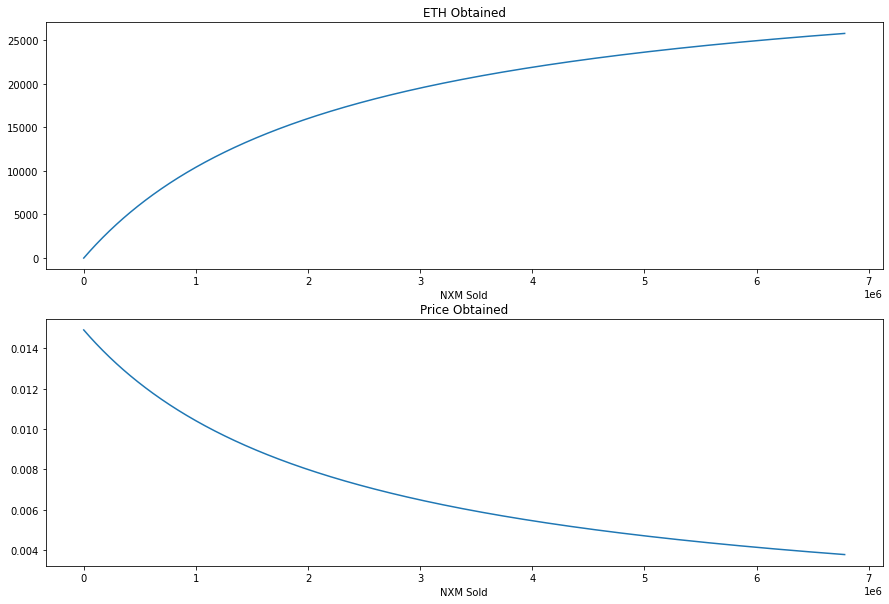

In [59]:
# sale size vs ETH and Price obtained 
sale_sizes = np.linspace(100, NexusSystem().nxm_supply, 1000)
eth_obtained = []
nxm_prices_obtained = []

for n_nxm in sale_sizes:
    sim = UniPool()
    sim.platform_nxm_sale(n_nxm)
    eth_obtained.append(sim.eth_sold)
    nxm_prices_obtained.append(sim.eth_sold / n_nxm)
    
fig, axs = plt.subplots(2, 1, figsize=(15,10))
axs[0].plot(sale_sizes, eth_obtained)
axs[0].set_title('ETH Obtained')
axs[0].set_xlabel('NXM Sold')
axs[1].plot(sale_sizes, nxm_prices_obtained)
axs[1].set_title('Price Obtained')
axs[1].set_xlabel('NXM Sold');

### Set up Single Simulation

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:05<00:00, 68.84it/s]


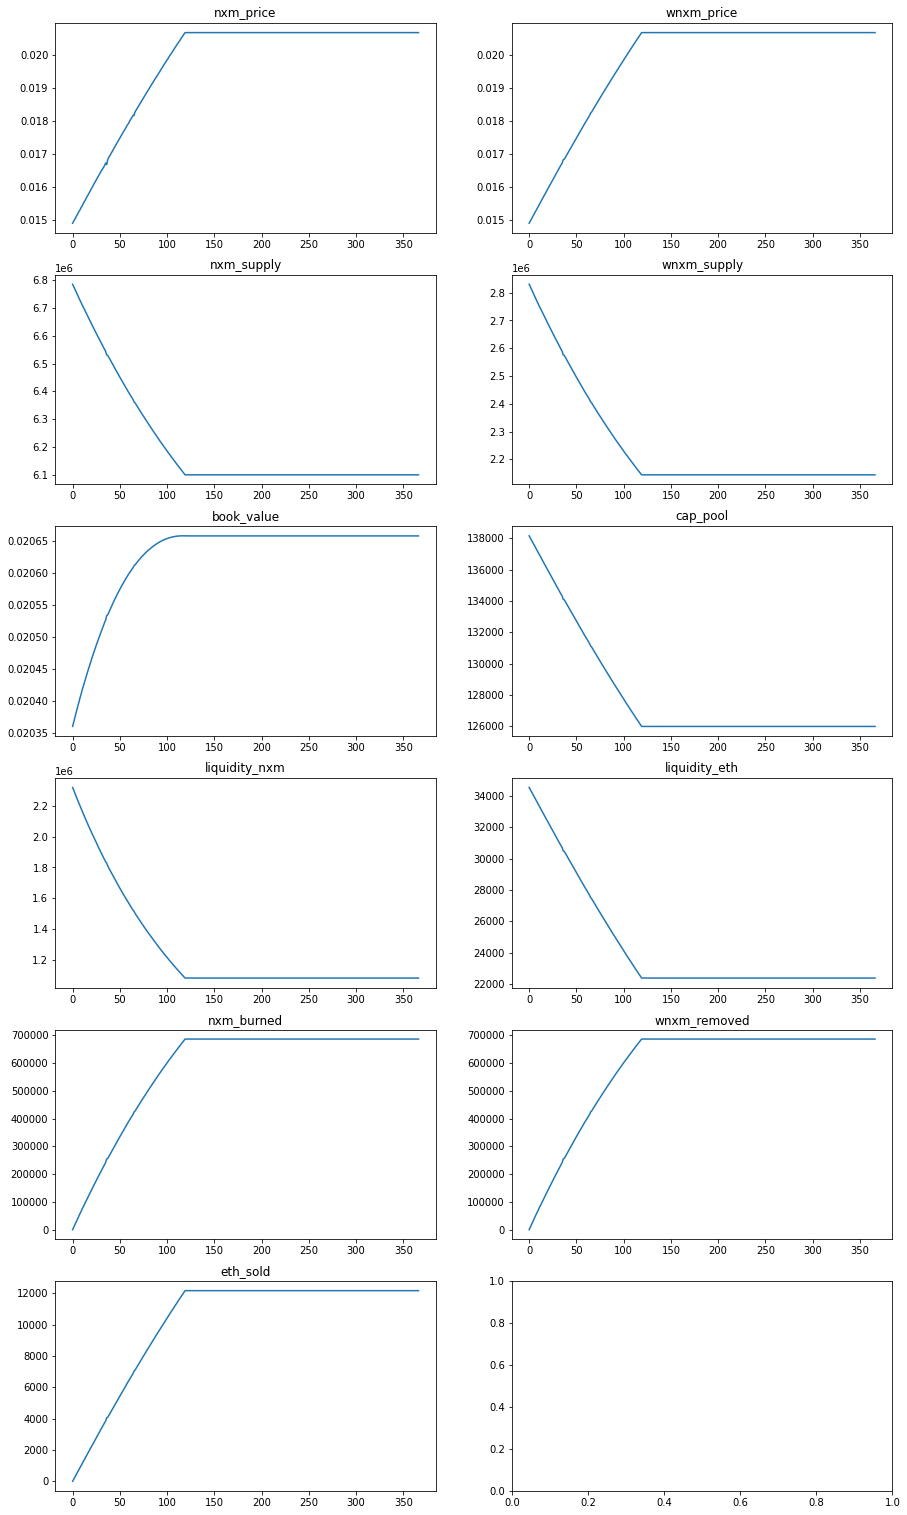

In [76]:
model_days = 366

sim = UniPool()

for i in tqdm(range(model_days)):
    sim.one_day_passes()
    
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(6, 2, figsize=(15,27)) # axs is a (6,2) nd-array

# Subplot
axs[0, 0].plot(range(model_days+1), sim.nxm_price_prediction)
axs[0, 0].set_title('nxm_price')
# Subplot
axs[0, 1].plot(range(model_days+1), sim.wnxm_price_prediction)
axs[0, 1].set_title('wnxm_price')
# Subplot
axs[1, 0].plot(range(model_days+1), sim.nxm_supply_prediction)
axs[1, 0].set_title('nxm_supply')
# Subplot
axs[1, 1].plot(range(model_days+1), sim.wnxm_supply_prediction)
axs[1, 1].set_title('wnxm_supply')
# Subplot
axs[2, 0].plot(range(model_days+1), sim.book_value_prediction)
axs[2, 0].set_title('book_value')
# Subplot
axs[2, 1].plot(range(model_days+1), sim.cap_pool_prediction)
axs[2, 1].set_title('cap_pool')
# Subplot
axs[3, 0].plot(range(model_days+1), sim.liquidity_nxm_prediction)
axs[3, 0].set_title('liquidity_nxm')
# Subplot
axs[3, 1].plot(range(model_days+1), sim.liquidity_eth_prediction)
axs[3, 1].set_title('liquidity_eth')
# Subplot
axs[4, 0].plot(range(model_days+1), sim.nxm_burned_prediction)
axs[4, 0].set_title('nxm_burned')
# Subplot
axs[4, 1].plot(range(model_days+1), sim.wnxm_removed_prediction)
axs[4, 1].set_title('wnxm_removed')
# Subplot
axs[5, 0].plot(range(model_days+1), sim.eth_sold_prediction)
axs[5, 0].set_title('eth_sold')

plt.show()